### Connect to Drive & import libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive
#%cd /gdrive/My Drive/[2023-2024] AN2DL/Homework 1

# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import cv2
from tensorflow.keras.applications.convnext import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

from sklearn.preprocessing import LabelEncoder

Mounted at /gdrive
/gdrive/My Drive
2.14.0


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns



### Load data

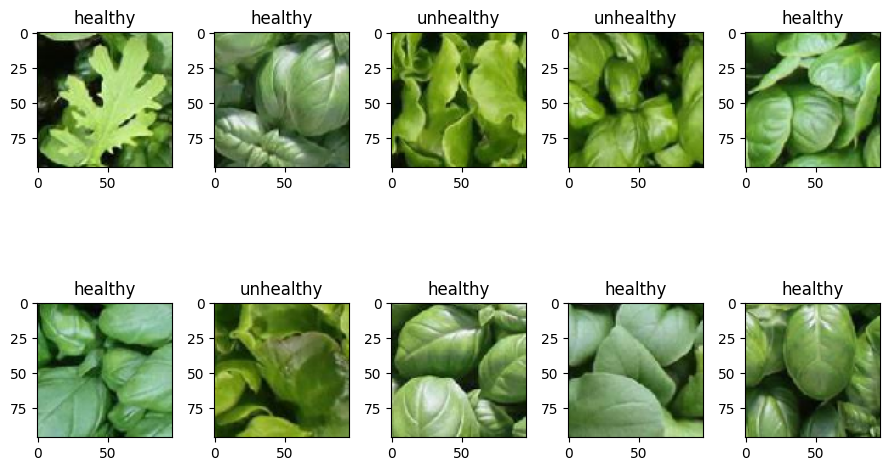

In [ ]:
# Reading the .npz file
dataset = np.load('public_data.npz', allow_pickle=True)

images = []

# Creating the array of images
for img in dataset['data']:
  img=(img).astype(np.float32)
  images.append(img)

images=np.array(images)

# Number of images to display
num_img = 10

# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(9, 6))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(images[i]/255, 0, 255))  # Display clipped item images
    ax.set_title('{}'.format(dataset['labels'][i]))

plt.tight_layout()
plt.show()


### Creating labels and sets

In [ ]:
y = []
count_h = 0
# Create an array with zeros and ones based on the tag
for i in range(len(images)):
    if dataset['labels'][i] == 'healthy':
        y.append(0)
    else:
        y.append(1)

# Convert labesl to one-hot encoding format
# i.e. 'healthy' -> [1,0], 'unhealty' -> [0,1]
y = tfk.utils.to_categorical(y,2)

In [ ]:
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(images, y, random_state=seed, test_size=0.1, stratify=y)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=y_train_val)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3880, 96, 96, 3), y_train shape: (3880, 2)
X_val shape: (485, 96, 96, 3), y_val shape: (485, 2)
X_test shape: (485, 96, 96, 3), y_test shape: (485, 2)


### Adding noise ONLY to the train set

In [ ]:
# Adding noise
X_train_noise = []

for image in X_train:
    # Adding noise to the image
    VARIABILITY = 30
    deviation = VARIABILITY * random.random()
    noise = np.random.normal(0, deviation, image.shape)
    image += noise
    np.clip(image, 0., 255., out=image)
    X_train_noise.append(image)

X_train = np.array(X_train_noise)

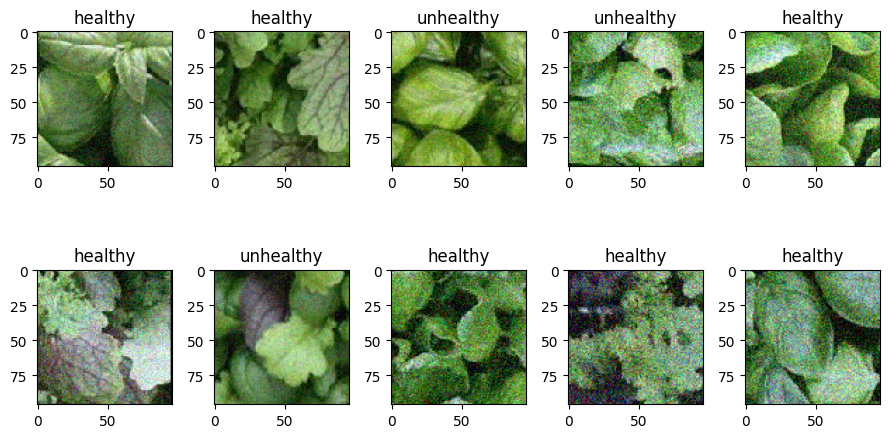

In [ ]:
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(9, 5))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(X_train[i]/255, 0, 255))  # Display clipped item images
    ax.set_title('{}'.format(dataset['labels'][i]))

plt.tight_layout()
plt.show()

In [ ]:
# Class weights to balance classes
ymax = np.argmax(y_train, axis=1)
weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(np.argmax(y_train, axis=1)),
                                                 y=ymax)
print(weights)

class_weights = {0: weights[0], 1: weights[1]}

[0.79248366 1.3547486 ]


## Transfer learning

In [ ]:
model_name = 'CBN_7'

In [ ]:
# Defining input and output shapes
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

# Print the shapes of the resulting datasets
print(input_shape)
print(output_shape)

(96, 96, 3)
(2,)


In [ ]:
# Loading the CNB net - we added the final GAP here
convnext = tf.keras.applications.ConvNeXtBase(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    include_preprocessing=True,
    pooling="avg"
)
convnext.trainable = False

# Display the model architecture with input shapes - useful for deciding where to freeze
#tfk.utils.plot_model(nnl, show_shapes=True)

In [ ]:
# Data augmentation
aug = tfk.Sequential([
  tfkl.RandomFlip('horizontal_and_vertical'),
  tfkl.RandomRotation(0.5),
  tfkl.RandomTranslation(0.25, 0.25),
  tfkl.RandomZoom(0.3),
  tfkl.RandomBrightness(0.2, value_range=(0,255)),
  tfkl.RandomContrast(0.2),
], name='data_aug')

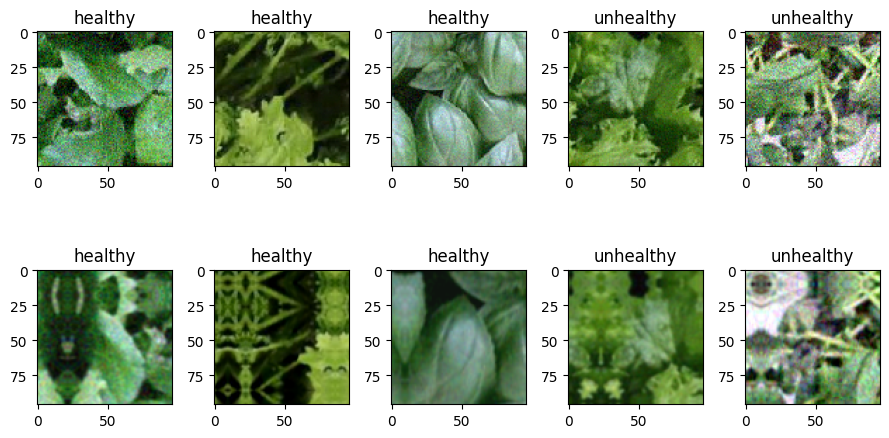

In [ ]:
# Example images of the data augmentation used in the network
fig, axes = plt.subplots(2, 10//2, figsize=(9, 5))
for i in range(10):
    if(i < 5):
      ax = axes[0, i%5]
      ax.imshow(np.clip(X_train[i%5]/255, 0, 255))  # Display clipped item images
    else:
      ax = axes[1, i%5]
      ax.imshow(np.clip(aug(X_train[i%5])/255, 0, 255))  # Display clipped item images
    ax.set_title('{}'.format(dataset['labels'][i%5]))

plt.tight_layout()
plt.show()

In [ ]:
# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=input_shape, name='Input')

# Data augmentation
data_aug = tfk.Sequential([
  tfkl.RandomFlip('horizontal_and_vertical'),
  tfkl.RandomRotation(0.5),
  tfkl.RandomTranslation(0.25, 0.25),
  tfkl.RandomZoom(0.3),
  tfkl.RandomBrightness(0.2, value_range=(0,255)),
  tfkl.RandomContrast(0.2),
], name='data_aug')

x = data_aug(inputs)

x = convnext(x, training=False)

# Leaky ReLU after the CNB (with final GAP)
x = tfkl.LeakyReLU()(x)

# Dense layer + dropout & weight decay series
l2_lambda = 2e-6
dropout_rate = 1/5

x = tfkl.Dense(units=1000, activation='gelu', kernel_initializer=tfk.initializers.HeUniform(seed=seed), kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), name='dense1')(x)
x = tfkl.Dropout(dropout_rate)(x)

x = tfkl.Dense(units=550, activation='gelu', kernel_initializer=tfk.initializers.HeUniform(seed=seed), kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), name='dense2')(x)
x = tfkl.Dropout(dropout_rate)(x)

x = tfkl.Dense(units=205, activation='gelu', kernel_initializer=tfk.initializers.HeUniform(seed=seed), kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), name='dense3')(x)
x = tfkl.Dropout(dropout_rate)(x)

# Add a last Dense layer as classifier
outputs=tfkl.Dense(2, activation='sigmoid')(x)

model = tfk.Model(inputs=inputs, outputs=outputs, name=model_name)


smoothing = 0.15;
learning_rate = 1e-3;
# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.CategoricalCrossentropy(label_smoothing=smoothing), optimizer=tfk.optimizers.Adam(learning_rate), metrics=['accuracy'])

# Display model summary
model.summary()

Model: "CBN_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 data_aug (Sequential)       (None, 96, 96, 3)         0         
                                                                 
 convnext_base (Functional)  (None, 1024)              87566464  
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense1 (Dense)              (None, 1000)              1025000   
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense2 (Dense)              (None, 550)               550550

In [ ]:
# Train the model
history = model.fit(
    x = X_train, # We need to apply the preprocessing thought
    y = y_train,
    class_weight=class_weights,
    batch_size = 128,
    epochs = 400,
    validation_data = (X_val, y_val), # We need to apply the preprocessing thought
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=25, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=4, factor=0.95, min_lr=5e-4)]
).history

Epoch 1/400
32/32 [==============================] - 48s 874ms/step - loss: 0.7663 - accuracy: 0.5778 - val_loss: 0.6047 - val_accuracy: 0.7025 - lr: 0.0010
Epoch 2/400
32/32 [==============================] - 16s 516ms/step - loss: 0.6384 - accuracy: 0.6795 - val_loss: 0.5340 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/400
32/32 [==============================] - 15s 482ms/step - loss: 0.6058 - accuracy: 0.7091 - val_loss: 0.5441 - val_accuracy: 0.8275 - lr: 0.0010
Epoch 4/400
32/32 [==============================] - 15s 479ms/step - loss: 0.5899 - accuracy: 0.7274 - val_loss: 0.5372 - val_accuracy: 0.7875 - lr: 0.0010
Epoch 5/400
32/32 [==============================] - 15s 483ms/step - loss: 0.5843 - accuracy: 0.7496 - val_loss: 0.5259 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 6/400
32/32 [==============================] - 16s 494ms/step - loss: 0.5824 - accuracy: 0.7326 - val_loss: 0.5385 - val_accuracy: 0.7825 - lr: 0.0010
Epoch 7/400
32/32 [==============================] - 15s 4

Max validation accuracy:  0.887499988079071
Predictions Shape: (400, 2)
Accuracy: 0.8525
Precision: 0.8726
Recall: 0.8132
F1: 0.8302


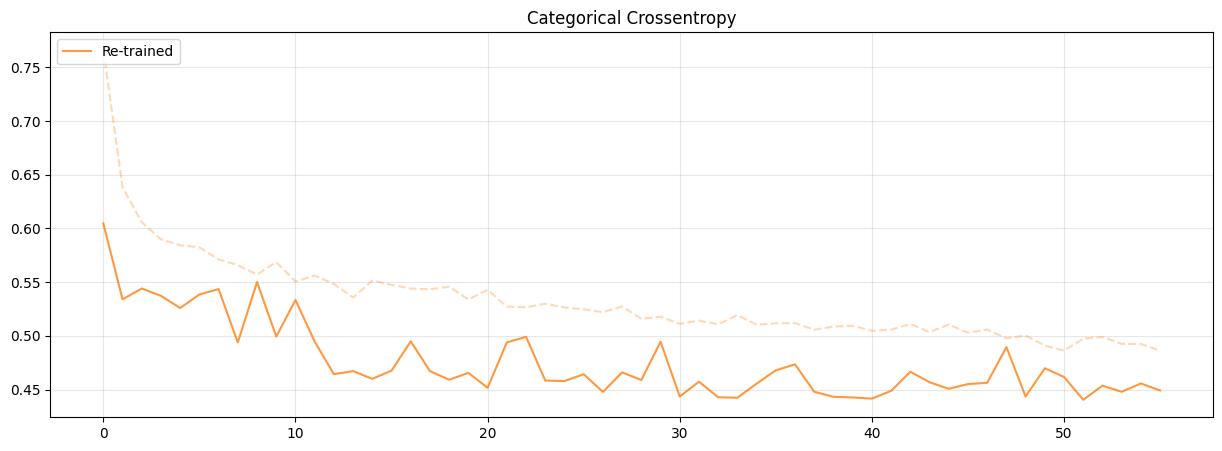

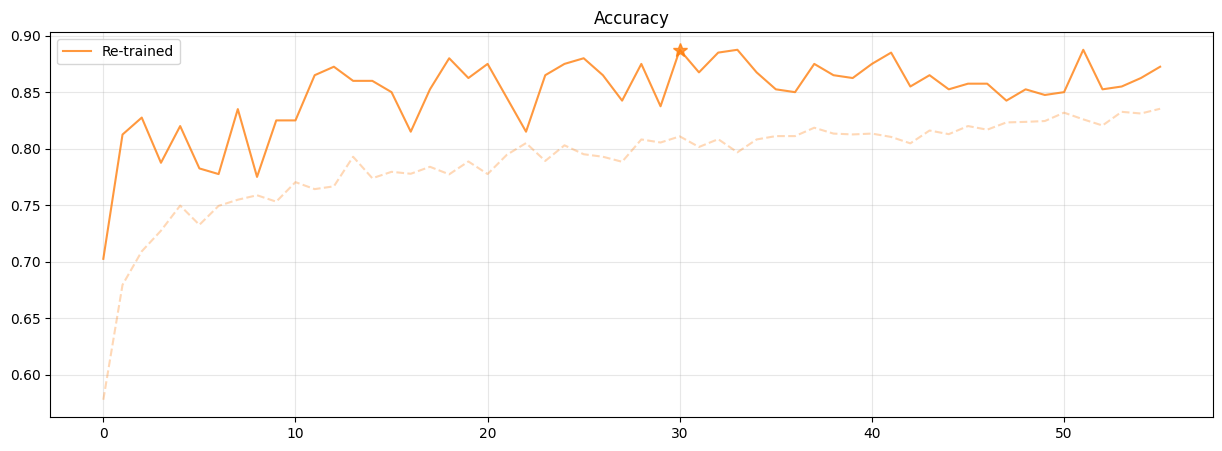

In [ ]:
print('Max validation accuracy: ', max(history['val_accuracy']))

# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot the re-trained EfficientNetB2 training history
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
model.save(model_name)
del model

## Fine Tuning



In [ ]:
model = tfk.models.load_model(model_name)

In [ ]:
# Re-load the model after transfer learning
model.get_layer('convnext_base').trainable = True
model.summary()

Model: "CBN_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 data_aug (Sequential)       (None, 96, 96, 3)         0         
                                                                 
 convnext_base (Functional)  (None, 1024)              87566464  
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense1 (Dense)              (None, 1000)              1025000   
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense2 (Dense)              (None, 550)               550550

In [ ]:
# See all trainable layers
for i, layer in enumerate(model.get_layer('convnext_base').layers):
   print(i, layer.name, layer.trainable)

0 input_2 True
1 convnext_base_prestem_normalization True
2 convnext_base_stem True
3 convnext_base_stage_0_block_0_depthwise_conv True
4 convnext_base_stage_0_block_0_layernorm True
5 convnext_base_stage_0_block_0_pointwise_conv_1 True
6 convnext_base_stage_0_block_0_gelu True
7 convnext_base_stage_0_block_0_pointwise_conv_2 True
8 convnext_base_stage_0_block_0_layer_scale True
9 convnext_base_stage_0_block_0_identity True
10 tf.__operators__.add_36 True
11 convnext_base_stage_0_block_1_depthwise_conv True
12 convnext_base_stage_0_block_1_layernorm True
13 convnext_base_stage_0_block_1_pointwise_conv_1 True
14 convnext_base_stage_0_block_1_gelu True
15 convnext_base_stage_0_block_1_pointwise_conv_2 True
16 convnext_base_stage_0_block_1_layer_scale True
17 convnext_base_stage_0_block_1_identity True
18 tf.__operators__.add_37 True
19 convnext_base_stage_0_block_2_depthwise_conv True
20 convnext_base_stage_0_block_2_layernorm True
21 convnext_base_stage_0_block_2_pointwise_conv_1 True
2

In [ ]:
# Freeze first N layers
N = 156
for i, layer in enumerate(model.get_layer('convnext_base').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('convnext_base').layers):
   print(i, layer.name, layer.trainable)
model.summary()

0 input_2 False
1 convnext_base_prestem_normalization False
2 convnext_base_stem False
3 convnext_base_stage_0_block_0_depthwise_conv False
4 convnext_base_stage_0_block_0_layernorm False
5 convnext_base_stage_0_block_0_pointwise_conv_1 False
6 convnext_base_stage_0_block_0_gelu False
7 convnext_base_stage_0_block_0_pointwise_conv_2 False
8 convnext_base_stage_0_block_0_layer_scale False
9 convnext_base_stage_0_block_0_identity False
10 tf.__operators__.add_36 False
11 convnext_base_stage_0_block_1_depthwise_conv False
12 convnext_base_stage_0_block_1_layernorm False
13 convnext_base_stage_0_block_1_pointwise_conv_1 False
14 convnext_base_stage_0_block_1_gelu False
15 convnext_base_stage_0_block_1_pointwise_conv_2 False
16 convnext_base_stage_0_block_1_layer_scale False
17 convnext_base_stage_0_block_1_identity False
18 tf.__operators__.add_37 False
19 convnext_base_stage_0_block_2_depthwise_conv False
20 convnext_base_stage_0_block_2_layernorm False
21 convnext_base_stage_0_block_2_po

In [ ]:
model.compile(loss=tfk.losses.CategoricalCrossentropy(label_smoothing=smoothing), optimizer=tfk.optimizers.Adam(3e-4), metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    x = X_train, # We need to apply the preprocessing thought
    y = y_train,
    batch_size = 128,
    epochs = 400,
    class_weight=class_weights,
    validation_data = (X_val, y_val), # We need to apply the preprocessing thought
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.95, min_lr=5e-5)]
).history

Epoch 1/400
31/31 [==============================] - 106s 1s/step - loss: 0.5558 - accuracy: 0.7817 - val_loss: 0.4634 - val_accuracy: 0.8371 - lr: 3.0000e-04
Epoch 2/400
31/31 [==============================] - 26s 827ms/step - loss: 0.4961 - accuracy: 0.8289 - val_loss: 0.4597 - val_accuracy: 0.8474 - lr: 3.0000e-04
Epoch 3/400
31/31 [==============================] - 26s 846ms/step - loss: 0.4766 - accuracy: 0.8505 - val_loss: 0.4219 - val_accuracy: 0.8845 - lr: 3.0000e-04
Epoch 4/400
31/31 [==============================] - 26s 847ms/step - loss: 0.4522 - accuracy: 0.8680 - val_loss: 0.4287 - val_accuracy: 0.8804 - lr: 3.0000e-04
Epoch 5/400
31/31 [==============================] - 26s 831ms/step - loss: 0.4511 - accuracy: 0.8735 - val_loss: 0.4122 - val_accuracy: 0.8969 - lr: 3.0000e-04
Epoch 6/400
31/31 [==============================] - 26s 853ms/step - loss: 0.4218 - accuracy: 0.8889 - val_loss: 0.4086 - val_accuracy: 0.8948 - lr: 3.0000e-04
Epoch 7/400
31/31 [=================

Max validation accuracy:  0.9195876121520996
Predictions Shape: (485, 2)
Accuracy: 0.9258
Precision: 0.929
Recall: 0.911
F1: 0.9187


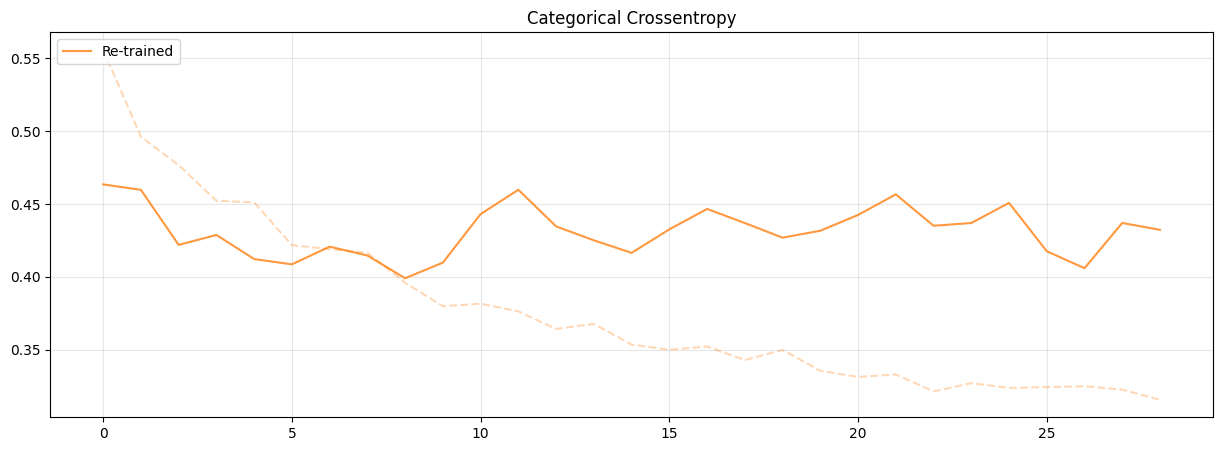

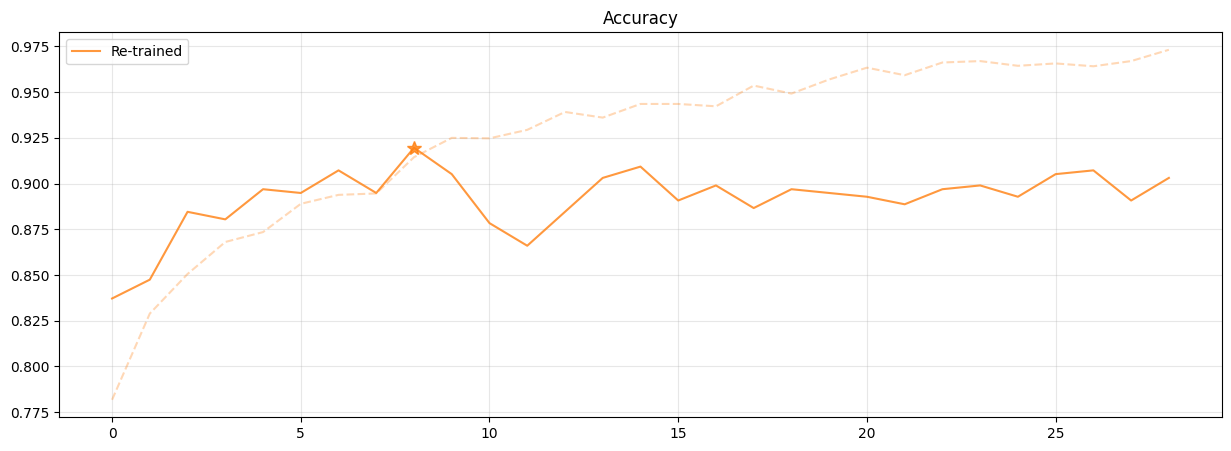

In [ ]:
print('Max validation accuracy: ', max(history['val_accuracy']))

# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot the re-trained EfficientNetB2 training history
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
model.save(model_name)
del model

## Fine tuning pt2

In [ ]:
model = tfk.models.load_model(model_name)

In [ ]:
# Re-load the model after transfer learning
model.get_layer('convnext_base').trainable = True
model.summary()

Model: "CBN_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 data_aug (Sequential)       (None, 96, 96, 3)         0         
                                                                 
 convnext_base (Functional)  (None, 1024)              87566464  
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense1 (Dense)              (None, 1000)              1025000   
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense2 (Dense)              (None, 550)               550550

In [ ]:
# See all trainable layers
for i, layer in enumerate(model.get_layer('convnext_base').layers):
   print(i, layer.name, layer.trainable)

0 input_2 True
1 convnext_base_prestem_normalization True
2 convnext_base_stem True
3 convnext_base_stage_0_block_0_depthwise_conv True
4 convnext_base_stage_0_block_0_layernorm True
5 convnext_base_stage_0_block_0_pointwise_conv_1 True
6 convnext_base_stage_0_block_0_gelu True
7 convnext_base_stage_0_block_0_pointwise_conv_2 True
8 convnext_base_stage_0_block_0_layer_scale True
9 convnext_base_stage_0_block_0_identity True
10 tf.__operators__.add_36 True
11 convnext_base_stage_0_block_1_depthwise_conv True
12 convnext_base_stage_0_block_1_layernorm True
13 convnext_base_stage_0_block_1_pointwise_conv_1 True
14 convnext_base_stage_0_block_1_gelu True
15 convnext_base_stage_0_block_1_pointwise_conv_2 True
16 convnext_base_stage_0_block_1_layer_scale True
17 convnext_base_stage_0_block_1_identity True
18 tf.__operators__.add_37 True
19 convnext_base_stage_0_block_2_depthwise_conv True
20 convnext_base_stage_0_block_2_layernorm True
21 convnext_base_stage_0_block_2_pointwise_conv_1 True
2

In [ ]:
model.compile(loss=tfk.losses.BinaryCrossentropy(label_smoothing=smoothing), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    x = X_train, # We need to apply the preprocessing thought
    y = y_train,
    batch_size = 128,
    epochs = 400,
    class_weight=class_weights,
    validation_data = (X_val, y_val), # We need to apply the preprocessing thought
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.95, min_lr=1e-6)]
).history

Epoch 1/400
31/31 [==============================] - 140s 2s/step - loss: 0.4630 - accuracy: 0.9281 - val_loss: 0.4505 - val_accuracy: 0.9155 - lr: 1.0000e-05
Epoch 2/400
31/31 [==============================] - 43s 1s/step - loss: 0.4424 - accuracy: 0.9302 - val_loss: 0.4325 - val_accuracy: 0.9155 - lr: 1.0000e-05
Epoch 3/400
31/31 [==============================] - 42s 1s/step - loss: 0.4206 - accuracy: 0.9351 - val_loss: 0.4198 - val_accuracy: 0.9113 - lr: 1.0000e-05
Epoch 4/400
31/31 [==============================] - 43s 1s/step - loss: 0.4014 - accuracy: 0.9490 - val_loss: 0.4109 - val_accuracy: 0.9113 - lr: 1.0000e-05
Epoch 5/400
31/31 [==============================] - 43s 1s/step - loss: 0.3994 - accuracy: 0.9405 - val_loss: 0.4065 - val_accuracy: 0.9155 - lr: 1.0000e-05
Epoch 6/400
31/31 [==============================] - 43s 1s/step - loss: 0.3899 - accuracy: 0.9451 - val_loss: 0.4006 - val_accuracy: 0.9175 - lr: 1.0000e-05
Epoch 7/400
31/31 [==============================] 

Max validation accuracy:  0.923711359500885
Predictions Shape: (485, 2)
Accuracy: 0.9299
Precision: 0.9309
Recall: 0.9178
F1: 0.9236


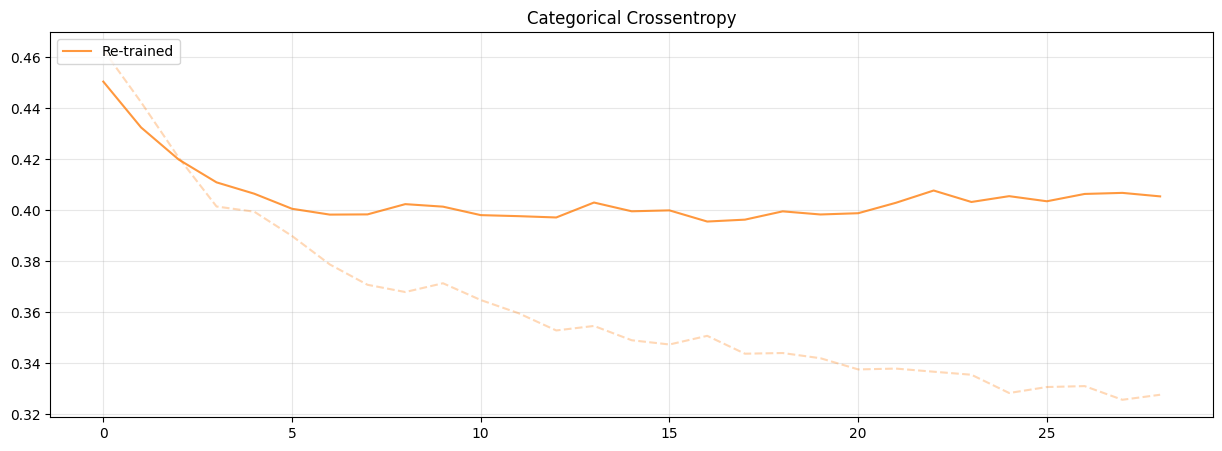

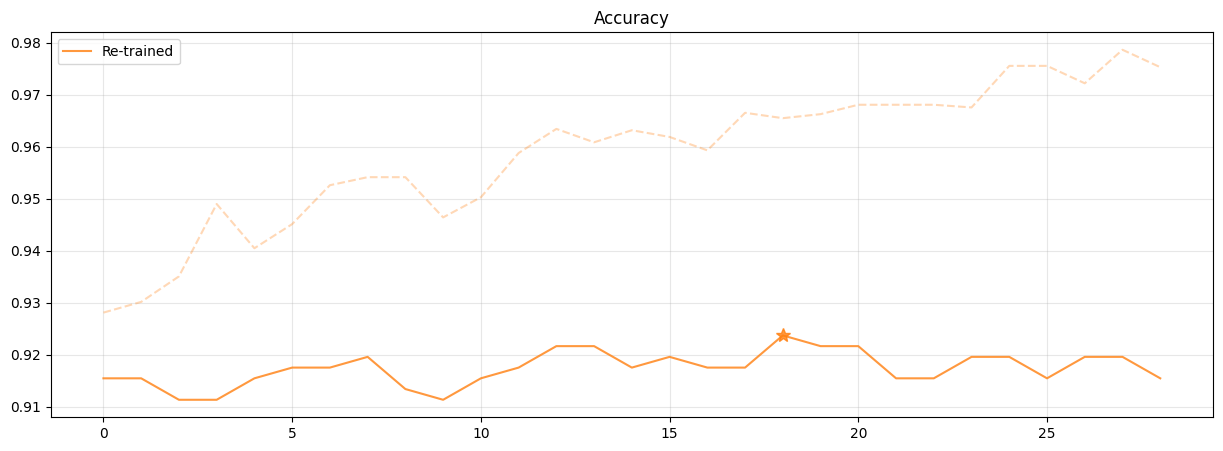

In [ ]:
print('Max validation accuracy: ', max(history['val_accuracy']))

# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot the re-trained EfficientNetB2 training history
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
model.save(model_name)
del model

## Test set + confusion matrix

In [ ]:
# Re-load the model after transfer learning
model = tfk.models.load_model(model_name)
model.summary()

Model: "CBN_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 data_aug (Sequential)       (None, 96, 96, 3)         0         
                                                                 
 convnext_base (Functional)  (None, 1024)              87566464  
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense1 (Dense)              (None, 1000)              1025000   
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense2 (Dense)              (None, 550)               550550

Predictions Shape: (485, 2)
Accuracy: 0.9299
Precision: 0.9309
Recall: 0.9178
F1: 0.9236


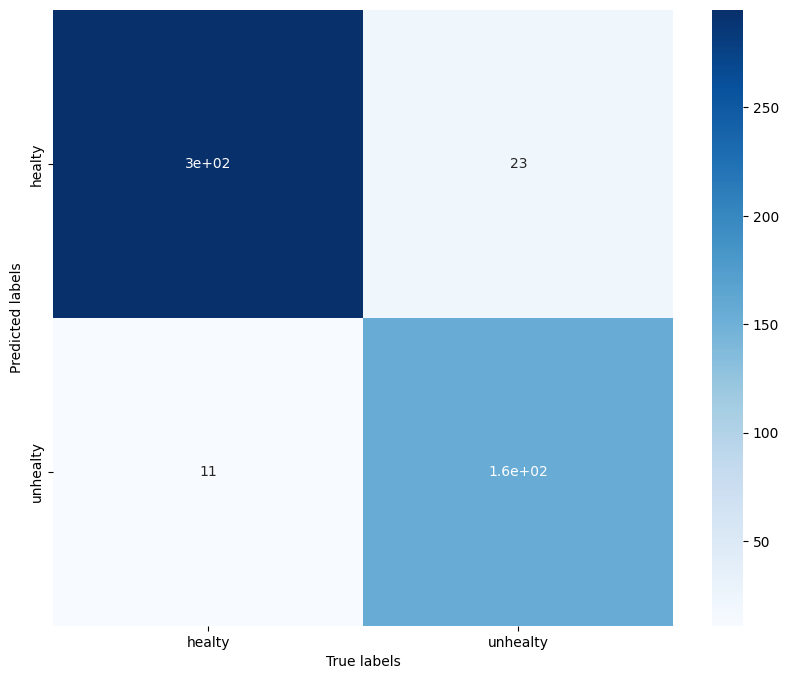

In [ ]:
model.reset_states()

# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healty','unhealty')), yticklabels=list(('healty','unhealty')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()